In [439]:
import pandas as pd
import os
import xml.etree.ElementTree as ET
from PIL import Image
from pathlib import Path
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters
from skimage import exposure
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [440]:
CWD = os.path.abspath(os.getcwd())
anotations = os.path.join(CWD, 'annotation')
images = os.path.join(CWD, 'images')


classes = ['n02113624-toy_poodle', 'n02093859-Kerry_blue_terrier', 'n02108422-bull_mastiff', 'n02085620-Chihuahua']

In [441]:
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

In [442]:
for cls in classes:
    org_images = os.path.join(images, cls)
    annotations = os.path.join(anotations, cls)
    
    annotations_files = [files for files in os.listdir(annotations)]
    
    for i in range(len(annotations_files)):
        bbox = get_bounding_boxes(os.path.join(annotations, annotations_files[i]))
        dog = os.path.join(org_images, annotations_files[i] + '.jpg')
        im = Image.open(dog)
        for j in range(len(bbox)):
            im2 = im.crop(bbox[j])
            im2 = im2.resize((331,331), Image.ANTIALIAS)
            new_path = dog.replace('images','Final_Images')
            im2 = im2.convert('RGB')
            head, tail = os.path.split(new_path)
            Path(head).mkdir(parents=True, exist_ok=True)
            im2.save(new_path)
        
        

C:\Users\Dell\AppData\Local\Temp\ipykernel_11476\174706395.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im2 = im2.resize((331,331), Image.ANTIALIAS)


## Image Processing

### pixel intensity histograms

In [443]:
def grayscale_histogram(filename, imgs):
    nrows = 4
    ncols = 2
    subplot_index = 1
    
    for i in range(len(imgs)):
        file_image = os.path.join(filename, imgs[i])
        color_img = cv2.imread(file_image)
        gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)

        plt.subplot(nrows, ncols, subplot_index)
        subplot_index += 1
        plt.imshow(gray_img, cmap = 'gray')
        plt.title('Dog grayscale image')
        plt.subplot(nrows, ncols, subplot_index)
        subplot_index += 1
        plt.hist(x = gray_img.ravel(), bins = 256, color = 'red')
        plt.title('Grayscale Histogram')
        plt.xlabel('Intensity')
        plt.ylabel('Pixel Count')
    
    plt.gcf().set_size_inches(17, 19)
    plt.tight_layout()
    plt.show()


toy_poodle


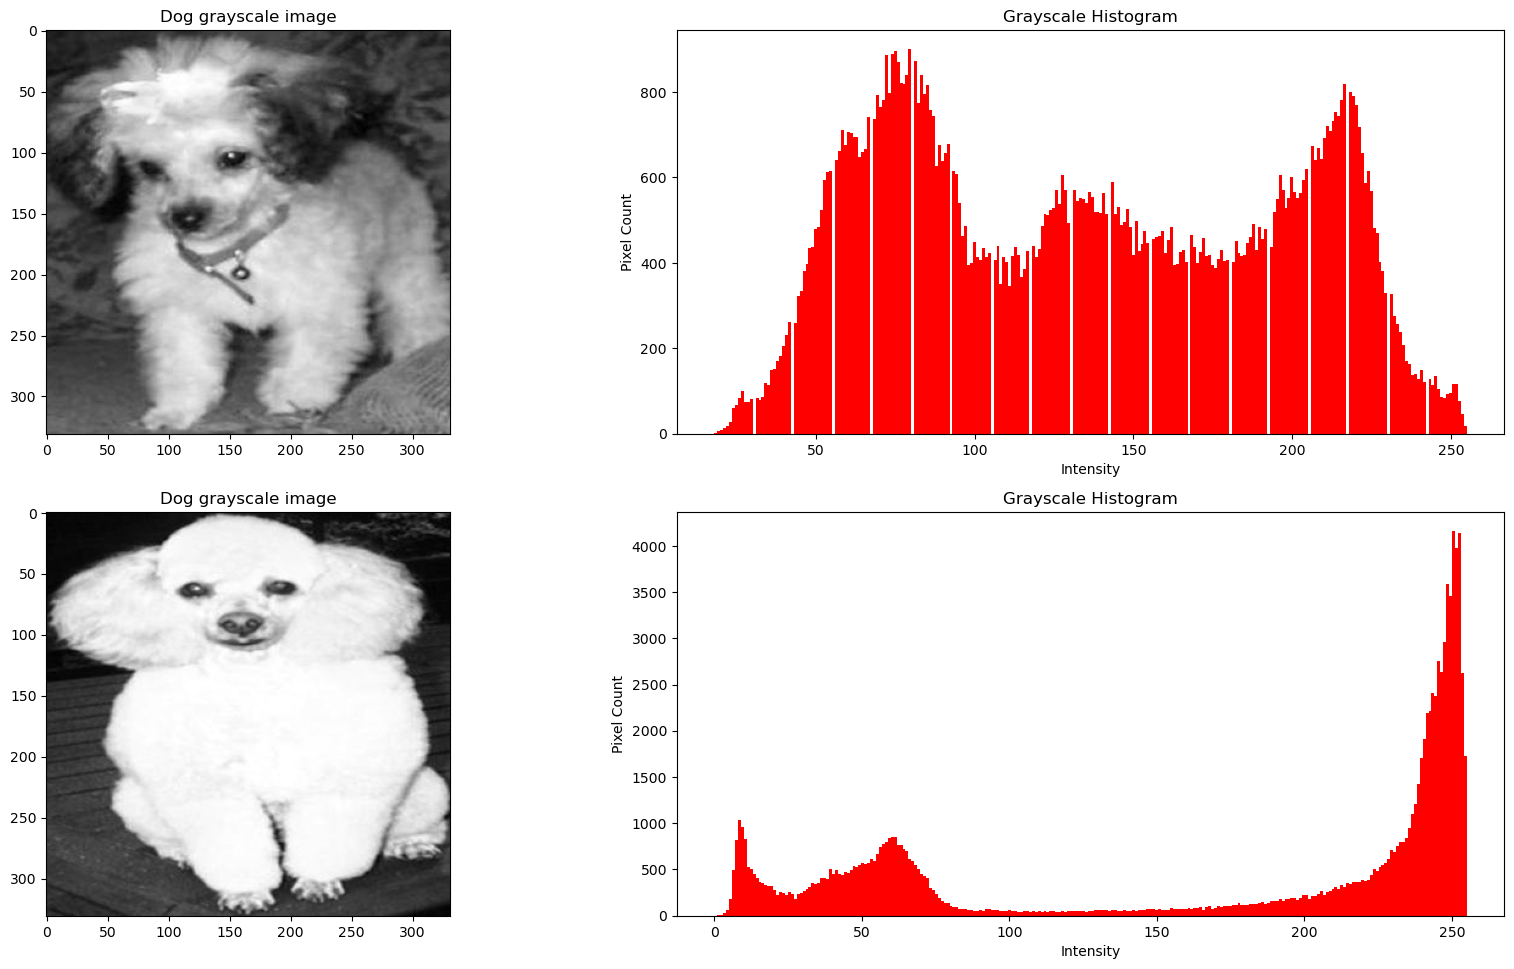

Kerry_blue_terrier


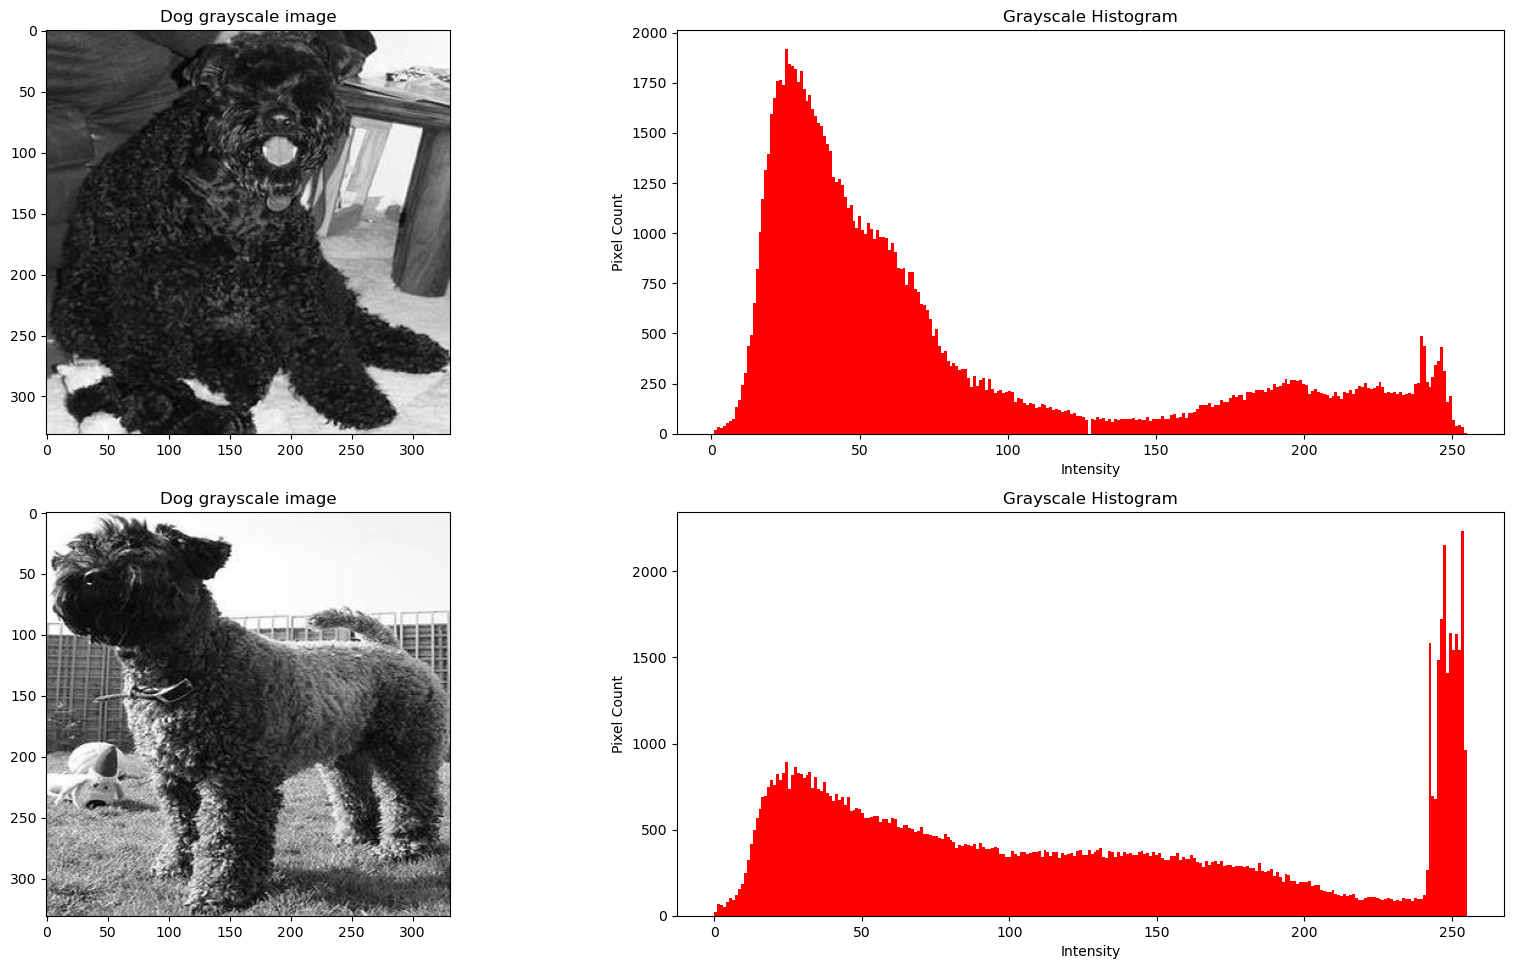

bull_mastiff


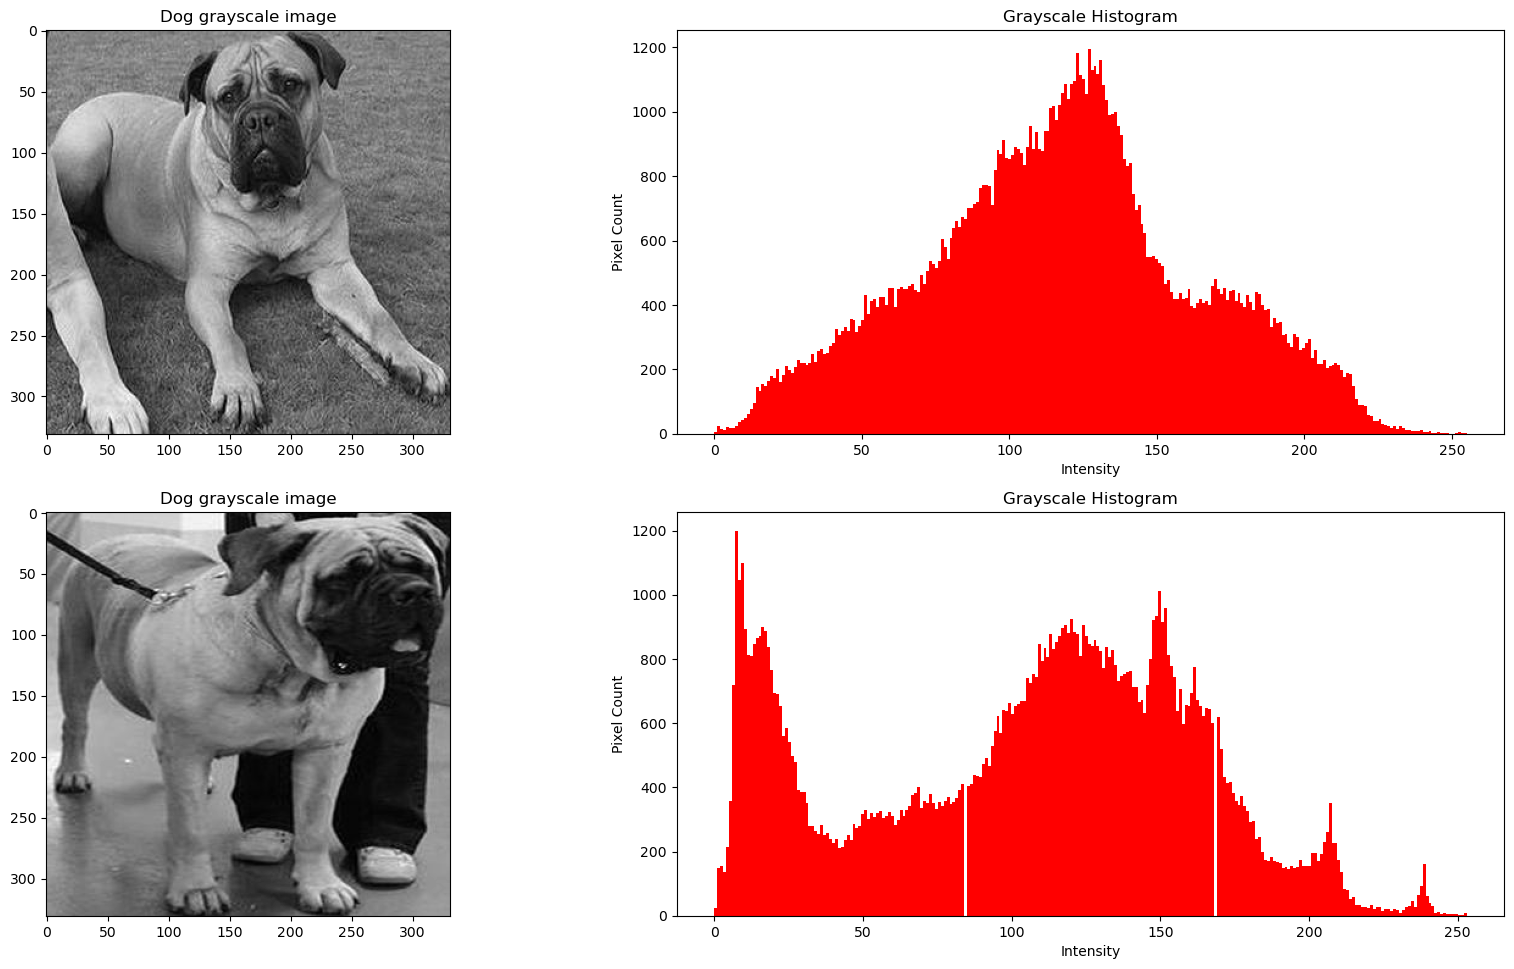

Chihuahua


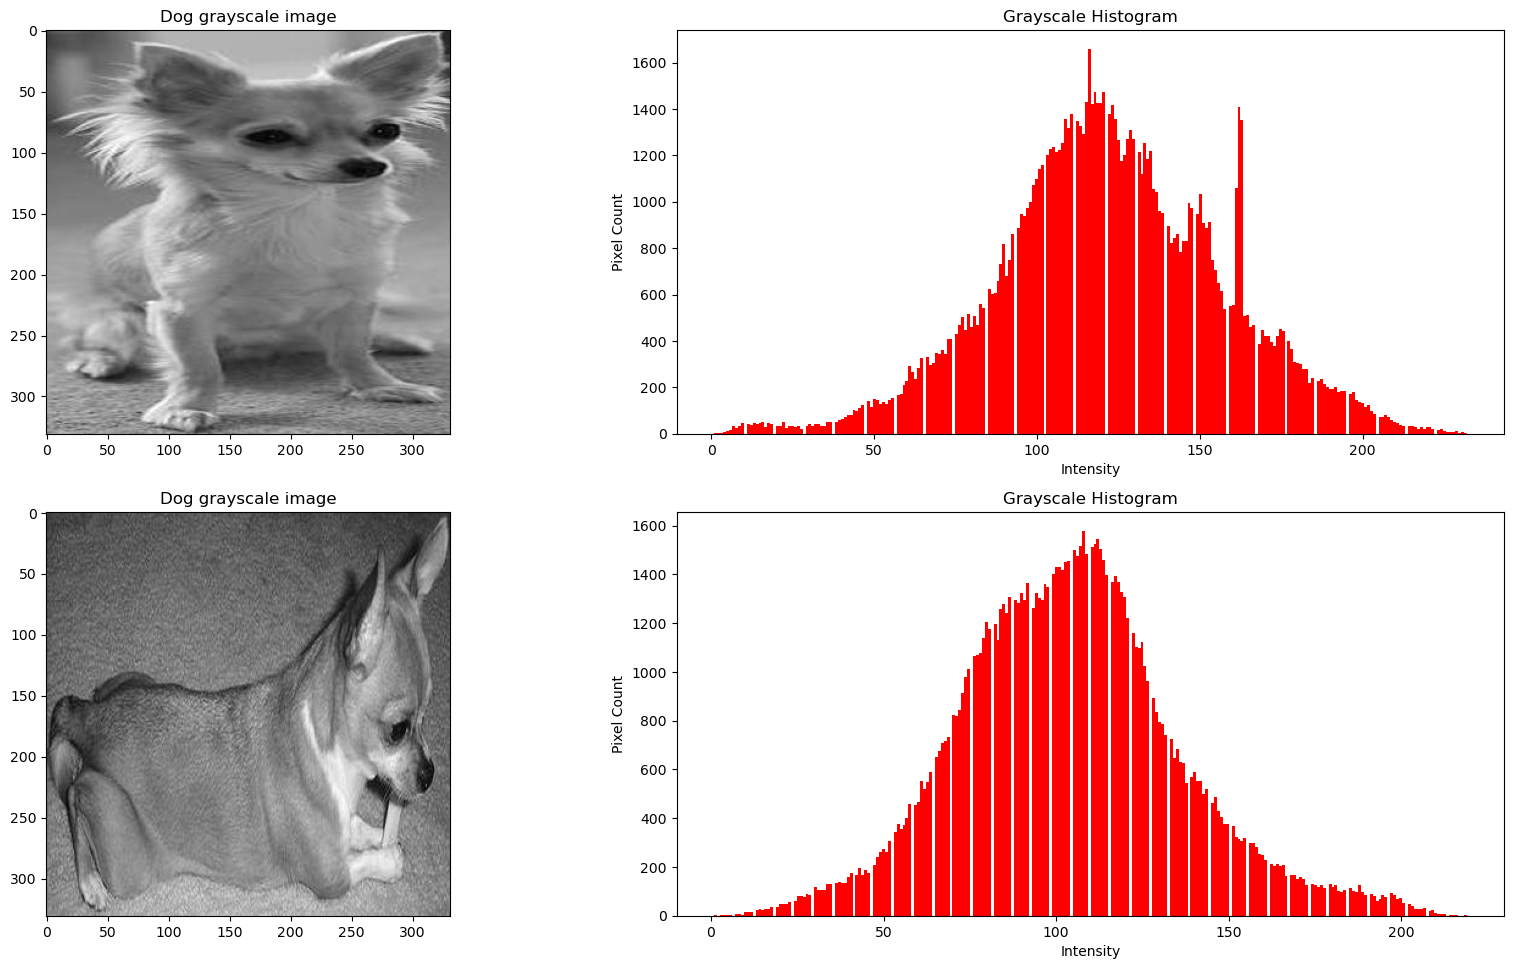

In [444]:
for cls in classes:
    imgs_filename = os.path.join(CWD, 'Final_images/' + cls)
    img_files = [files for files in os.listdir(imgs_filename)]
    print(cls.split('-')[1])
    grayscale_histogram(imgs_filename, img_files[4:6])

### Sobel Edge Detection

In [445]:
def edge_detection_img(filename, imgs):
    
    for i in range(len(imgs)):
        file_image = os.path.join(filename, imgs[i])
        color_img = cv2.imread(file_image)
        gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
        edge_sobel = filters.sobel(gray_img)
        
        fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
        
        axes[0].imshow(gray_img, cmap = 'gray')
        axes[0].set_title('Dog Grayscale Image')
        
        axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
        axes[1].set_title('Sobel Edge Detection')
        
        fig.tight_layout()

    plt.show()

toy_poodle


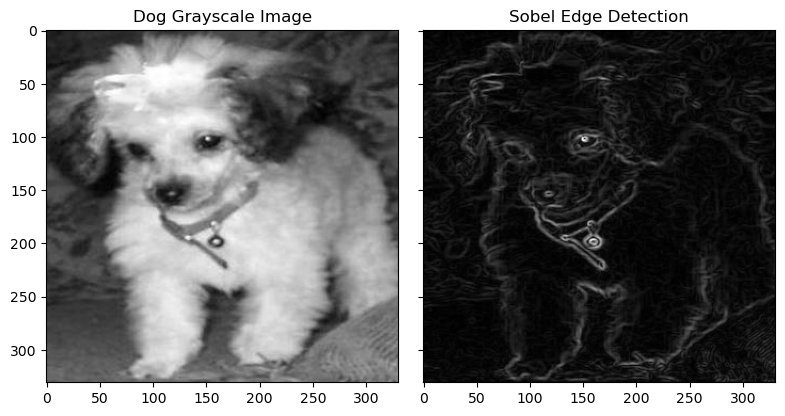

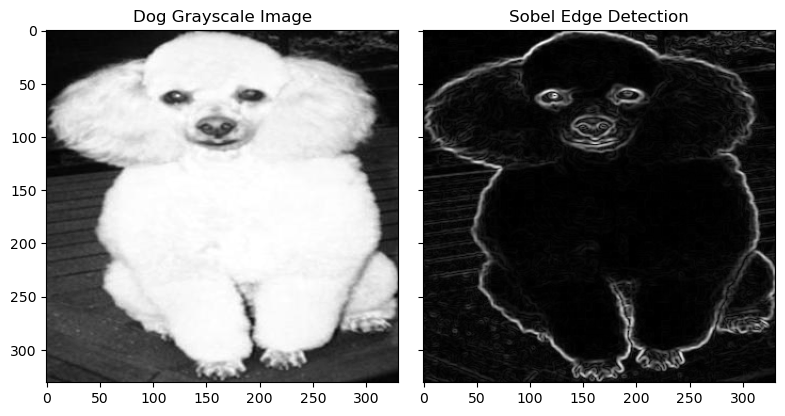

Kerry_blue_terrier


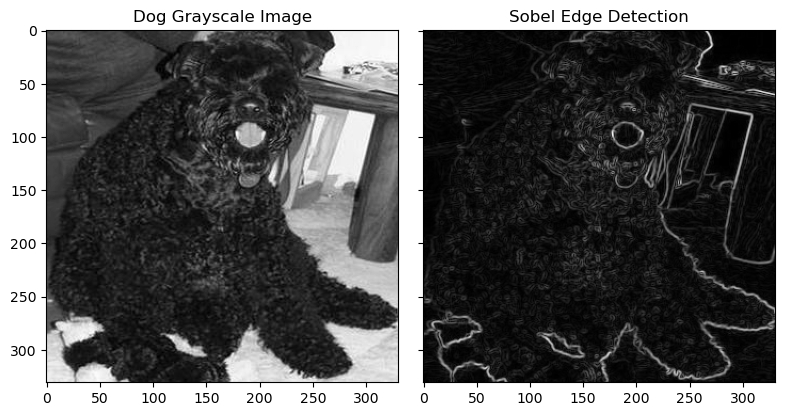

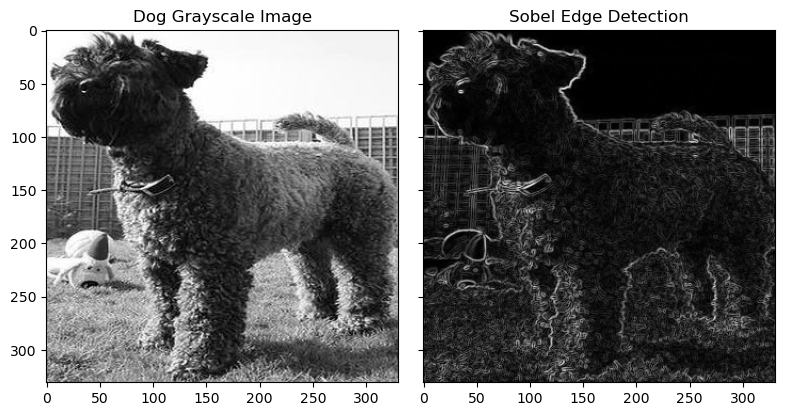

bull_mastiff


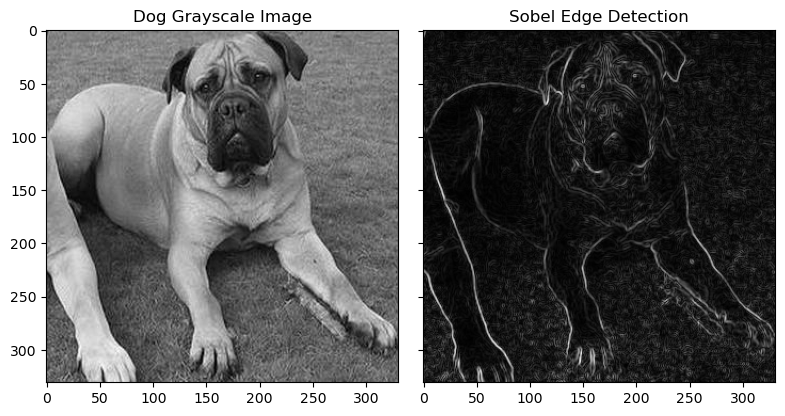

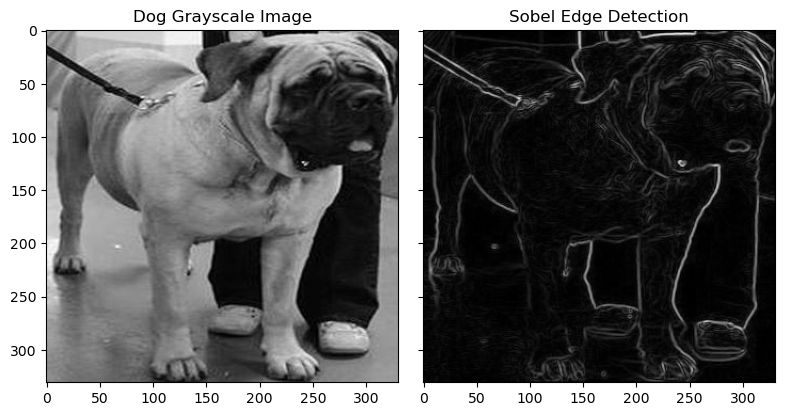

Chihuahua


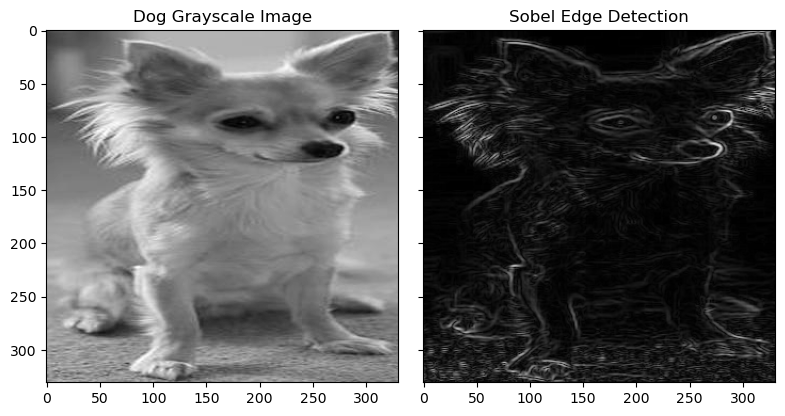

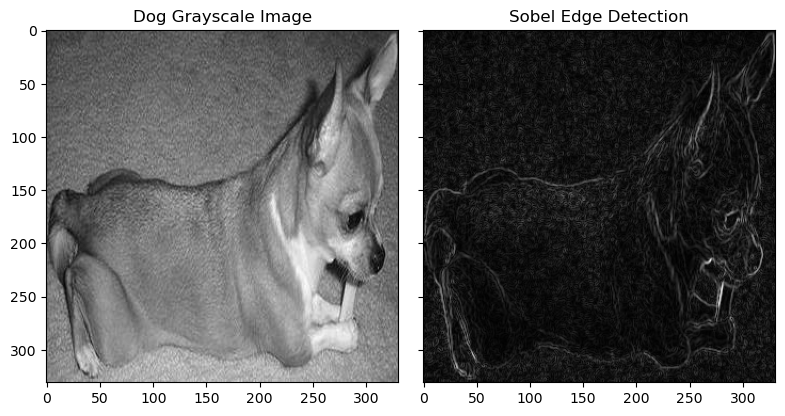

In [446]:
for cls in classes:
    imgs_filename = os.path.join(CWD, 'Final_images/' + cls)
    img_files = [files for files in os.listdir(imgs_filename)]
    print(cls.split('-')[1])
    edge_detection_img(imgs_filename, img_files[4:6])

## Edge histogram

In [457]:
def angle(dx, dy):
    #Calculate the angles between horizontal and vertical operators.
    return np.mod(np.arctan2(dy, dx), np.pi)

In [458]:
def exposure_histogram(grayscale_img, angle_sobel):
    nrows = 4
    ncols = 2
    subplot_index = 1

    fig, axes = plt.subplots(ncols=2, figsize=(13, 5))
    
    axes[0].imshow(grayscale_img, cmap='gray')
    axes[0].set_title('Dog Grayscale Image')
        
    hist, bins = exposure.histogram(angle_sobel.ravel(), nbins=36)
    
    axes[1].plot(bins, hist)
    axes[1].set_title('Edge Histogram')
    axes[1].set_xlabel('Bins')
    axes[1].set_ylabel('Pixel Count')
    
    plt.tight_layout()
    plt.show()

toy_poodle


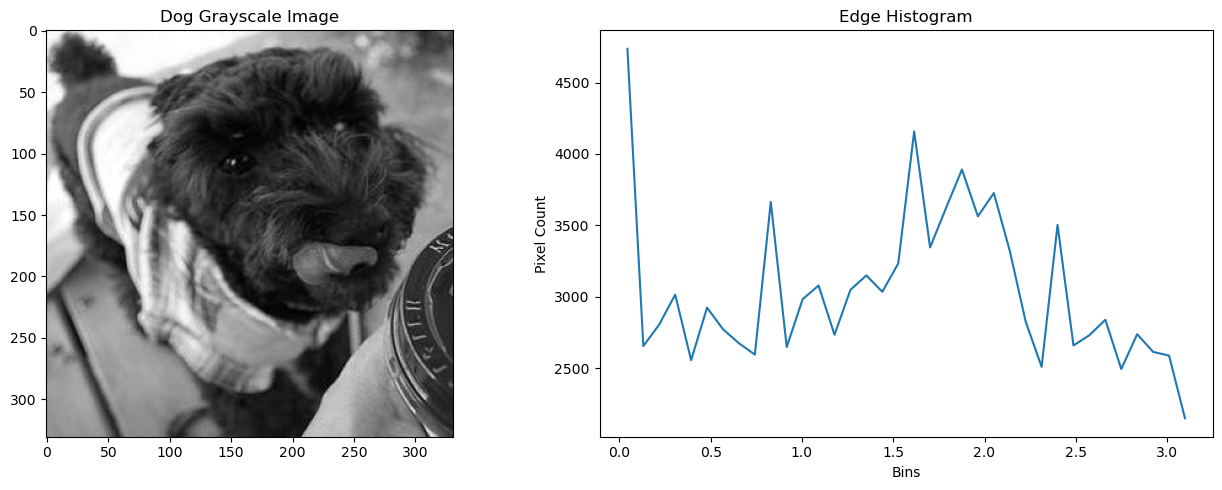

Kerry_blue_terrier


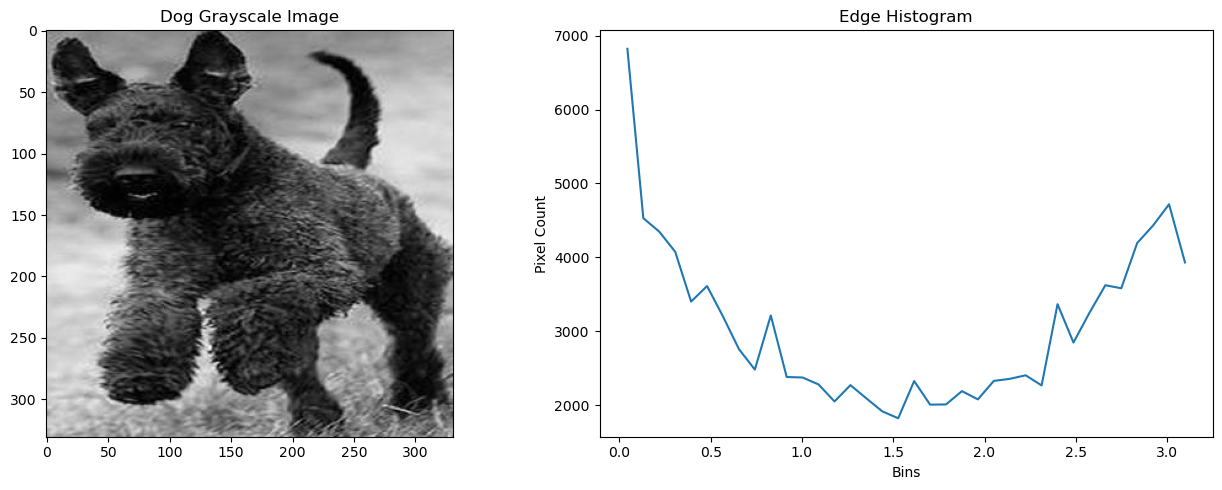

bull_mastiff


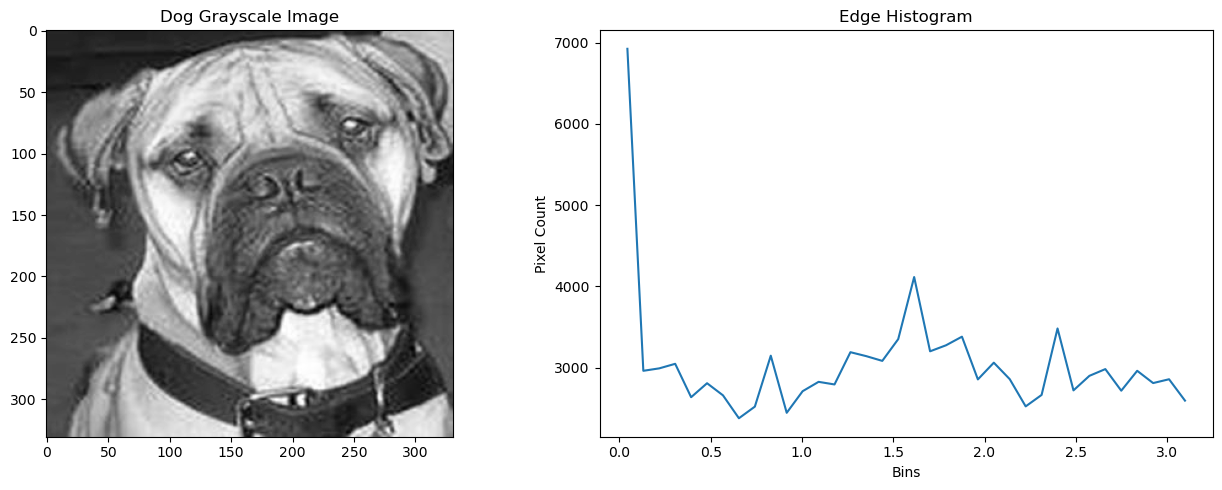

Chihuahua


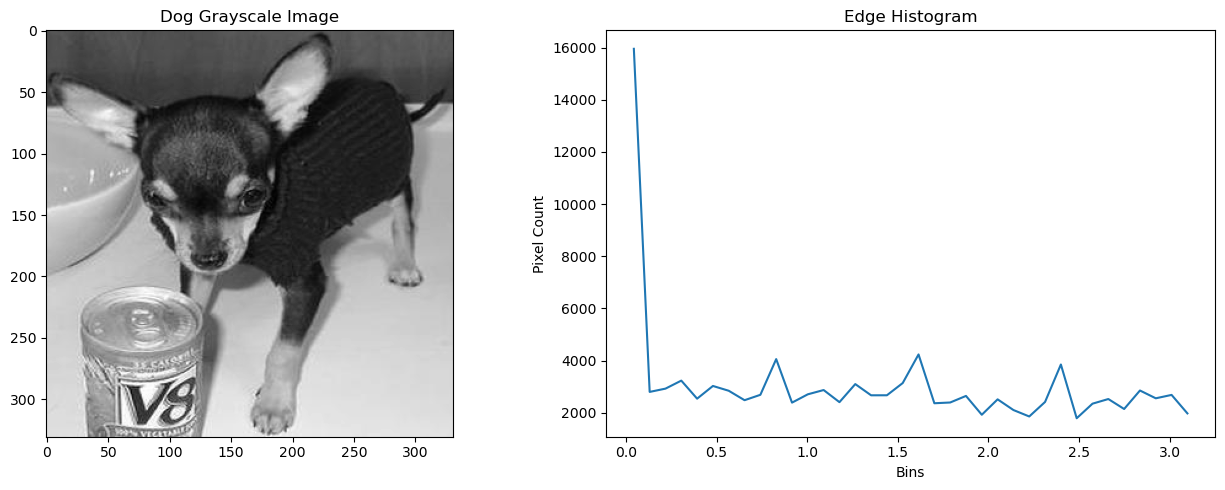

In [459]:
for cls in classes:
    imgs_filename = os.path.join(CWD, 'Final_images/' + cls)
    img_files = [files for files in os.listdir(imgs_filename)]

    random_img = random.choice(img_files)
    file_image = os.path.join(imgs_filename, random_img)
    color_img = cv2.imread(file_image)
    I = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    angle_sobel = angle(filters.sobel_h(I), filters.sobel_v(I))
    print(cls.split('-')[1])
    exposure_histogram(I, angle_sobel)

## Histogram Comparison (Measures of Similarity and Dissimilarity)

In [460]:
def edge_histogram(imgs_filename, img):
    file_image = os.path.join(imgs_filename, img)
    color_img = cv2.imread(file_image)
    I = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    angle_sobel = angle(filters.sobel_h(I), filters.sobel_v(I))
    hist, bins = exposure.histogram(angle_sobel, nbins=36)
    return hist

In [461]:
class_1_edge_hist = []
class_2_edge_hist = []

for i in range(0, 2):
    imgs_filename = os.path.join(CWD, 'Final_images/' + classes[i])
    img_files = [files for files in os.listdir(imgs_filename)]
    if i == 0:
        sameclass = random.sample(img_files, 2)
        for j in sameclass:
            class_1_edge_hist.append(edge_histogram(imgs_filename, j))
    else:
        otherclass = random.sample(img_files, 1)
        class_2_edge_hist.append(edge_histogram(imgs_filename, otherclass[0]))

#print(class_1_edge_hist)
#print(class_2_edge_hist)

Euclidean Distance

In [462]:
#same class
same_class_euclidean_dist = cv2.norm(class_1_edge_hist[0], class_1_edge_hist[1], normType = cv2.NORM_L2)
print('Euclidean distance between ' + classes[0].split('-')[1] + ' and ' + classes[0].split('-')[1] + ' class:', round(same_class_euclidean_dist, 2))

#diff class
diff_class_euclidean_dist = cv2.norm(class_1_edge_hist[0], class_2_edge_hist[0], normType = cv2.NORM_L2)
print('Euclidean distance between ' + classes[0].split('-')[1] + ' and ' + classes[1].split('-')[1] + ' class:', round(diff_class_euclidean_dist, 2))

Euclidean distance between toy_poodle and toy_poodle class: 4979.6
Euclidean distance between toy_poodle and Kerry_blue_terrier class: 10486.91


Manhattan Distance

In [463]:
def manhattan(A, B):
    return np.sum(np.abs(A - B))

#same class
same_class_manhattan_dist = manhattan(np.array(class_1_edge_hist[0]), np.array(class_1_edge_hist[1]))
print('Manhattan distance between ' + classes[0].split('-')[1] + ' and ' + classes[0].split('-')[1] + ' class:', round(same_class_manhattan_dist, 2))

#different class
diff_class_manhattan_dist = manhattan(np.array(class_1_edge_hist[0]), np.array(class_2_edge_hist[0]))
print('Manhattan distance between ' + classes[0].split('-')[1] + ' and ' + classes[1].split('-')[1] + ' class:', round(diff_class_manhattan_dist, 2))

Manhattan distance between toy_poodle and toy_poodle class: 24318
Manhattan distance between toy_poodle and Kerry_blue_terrier class: 50982


Cosine Distance

In [464]:
def cosine_distance(A, B):
    dot_product = np.sum(A * B)
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)
    return 1 - dot_product / (norm_A * norm_B)

#same class
same_class_cosine_dist = cosine_distance(np.array(class_1_edge_hist[0]), np.array(class_1_edge_hist[1]))
print('Cosine distance between ' + classes[0].split('-')[1] + ' and ' + classes[0].split('-')[1] + ' class:', round(same_class_cosine_dist, 2))

#different class
diff_class_cosine_dist = cosine_distance(np.array(class_1_edge_hist[0]), np.array(class_2_edge_hist[0]))
print('Cosine distance between ' + classes[0].split('-')[1] + ' and ' + classes[1].split('-')[1] + ' class:', round(diff_class_cosine_dist, 2))

Cosine distance between toy_poodle and toy_poodle class: 0.03
Cosine distance between toy_poodle and Kerry_blue_terrier class: 0.13


## Histogram of Oriented Gradient (HOG) feature descriptor

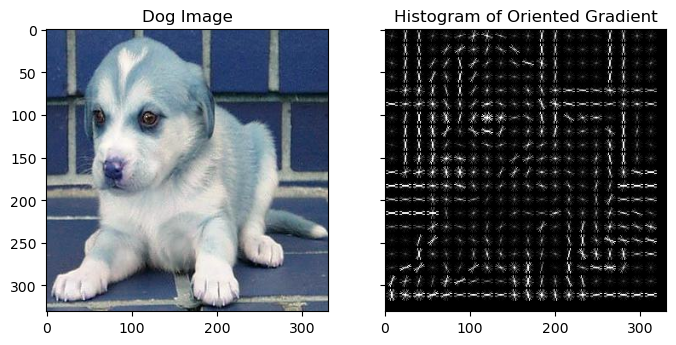

In [466]:
imgs_filename = os.path.join(CWD, 'Final_images/' + classes[3])
img_files = [files for files in os.listdir(imgs_filename)]
random_img = random.choice(img_files)
file_image = os.path.join(imgs_filename, random_img)
color_img = cv2.imread(file_image)

fd, hog_image = hog(color_img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax[0].imshow(color_img, cmap=plt.cm.gray)
ax[0].set_title('Dog Image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax[1].imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax[1].set_title('Histogram of Oriented Gradient')

plt.show()


## Dimensionality reduction (using Principal Component Analysis, PCA)

In [467]:
def edge_histogram(imgs_filename, img):
    file_image = os.path.join(imgs_filename, img)
    color_img = cv2.imread(file_image)
    I = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    angle_sobel = angle(filters.sobel_h(I), filters.sobel_v(I))
    hist, bins = exposure.histogram(angle_sobel, nbins=36)
    return hist

In [468]:
def PCA_dimensionality_reduction(edge_hist):
    pca = PCA(n_components = 2)
    pca_reduction_data = pca.fit_transform(edge_hist)
    return pca_reduction_data

In [469]:
KBT_edge_hist = []
Chihua_edge_hist = []

imgs_filename = os.path.join(CWD, 'Final_images/' + classes[3])
img_files = [files for files in os.listdir(imgs_filename)]

for img in img_files:
    KBT_edge_hist.append(edge_histogram(imgs_filename, img))

imgs_filename = os.path.join(CWD, 'Final_images/' + classes[2])
img_files = [files for files in os.listdir(imgs_filename)]

for img in img_files:
    Chihua_edge_hist.append(edge_histogram(imgs_filename, img))

In [470]:
Chihua_pca_reduction = PCA_dimensionality_reduction(Chihua_edge_hist)
KBT_pca_reduction = PCA_dimensionality_reduction(KBT_edge_hist)

In [471]:
pca_reduction_2_classes = np.append(KBT_pca_reduction, Chihua_pca_reduction, axis = 0)
Y_KBT = [1 for i in range(len(KBT_pca_reduction))]
Y_Chihua = [2 for i in range(len(Chihua_pca_reduction))]
Y = Y_KBT + Y_Chihua

#print(pca_reduction_2_classes)

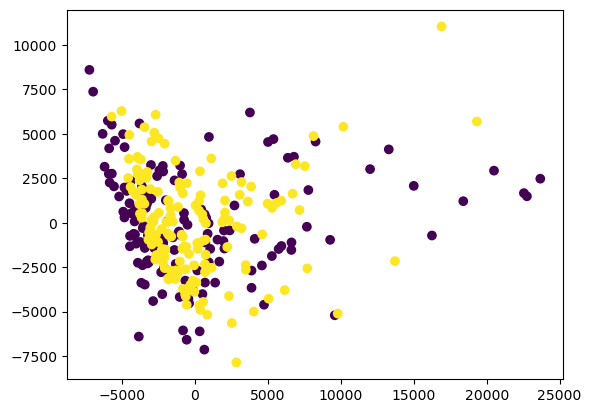

In [472]:
plt.scatter(pca_reduction_2_classes[:, 0], pca_reduction_2_classes[:, 1], c = np.array(Y))
plt.show()